## Calling External APIs with Tools in LangGraph Workflows

### Overview

This demo explains how to integrate **external API calls** into LangGraph workflows by building custom tools. It highlights the use of **real-time data retrieval** (quotes and web search) and shows how agents interact with external information sources.

In [ ]:
from typing import Dict
import requests
from tavily import TavilyClient
from langchain_core.tools import tool
from langchain_core.messages import (
    SystemMessage,
    HumanMessage, 
)
from langchain_openai import ChatOpenAI
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import MessagesState
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

### 1. **Setting up External API Tools**

In [3]:
@tool
def random_science_fact_tool()->Dict:
    """
    Return a random scientific fact and the field it belongs to
    """
    # Using the Numbers API to get random math facts
    response = requests.get("http://numbersapi.com/random/math")
    fact = response.text
    return {"fact": fact, "field": "Mathematics"}

In [6]:
random_science_fact_tool.invoke({})

{'fact': '863 is a value of n so that n(n+6) is a palindrome.',
 'field': 'Mathematics'}

In [7]:
tavily_client = TavilyClient()

In [8]:
@tool
def web_search(question:str)->Dict:
    """
    Return top search results for a given search query
    """
    response = tavily_client.search(question)
    return response

In [9]:
web_search.invoke(
    {
        "question": "Who discovered the theory of relativity?"
    }
)

{'query': 'Who discovered the theory of relativity?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Theory of relativity - Wikipedia',
   'url': 'https://en.wikipedia.org/wiki/Theory_of_relativity',
   'content': 'Video simulation of the merger GW150914, showing spacetime distortion from gravity as the black holes orbit and merge The theory of relativity usually encompasses two interrelated physics theories by Albert Einstein: special relativity and general relativity, proposed and published in 1905 and 1915, respectively. [1] Special relativity applies to all physical phenomena in the absence of gravity. General relativity explains the law of gravitation and its relation to the forces of nature. [3] The theory transformed theoretical physics and astronomy during the 20th century, superseding a 200-year-old theory of mechanics created primarily by Isaac Newton.',
   'score': 0.92005306,
   'raw_content': None},
  {'title': 'The Theory of Relativi

### 2. **Binding Tools to the LLM**

In [10]:
tools = [random_science_fact_tool, web_search]

In [11]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
)

In [12]:
llm_with_tools = llm.bind_tools(tools)

In [13]:
def agent(state: MessagesState):
    ai_message = llm_with_tools.invoke(state["messages"])
    return {"messages": ai_message}

### 3. **Router Logic**

In [14]:
def router(state: MessagesState):
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "tools"

    return END

### 4. **Workflow Construction**

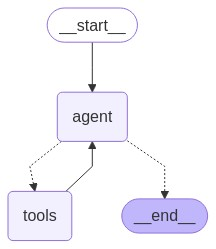

In [15]:
workflow = StateGraph(MessagesState)

workflow.add_node("agent", agent)
workflow.add_node("tools", ToolNode(tools))

workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    source="agent", 
    path=router, 
    path_map=["tools", END]
)

workflow.add_edge("tools", "agent")

graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

### 5. **Execution Example**

In [16]:
messages = [
    SystemMessage(
        "You are a Scientific Research Assistant. "
        "If user asks you for a random scientific fact, you will not only " 
        "provide it, but also search the web to find more context or related "
        "research about that fact. "
        "So, your output should include: The fact, the field it belongs to, and additional context."
    ),
    HumanMessage("Give me a random scientific fact")
]

In [17]:
result = graph.invoke(
    input={
        "messages": messages
    }
)

print(result)

{'messages': [SystemMessage(content='You are a Scientific Research Assistant. If user asks you for a random scientific fact, you will not only provide it, but also search the web to find more context or related research about that fact. So, your output should include: The fact, the field it belongs to, and additional context.', id='79204d8e-bf38-4734-950f-3e791e4880ec'), HumanMessage(content='Give me a random scientific fact', id='2089cfa4-7c6d-477f-b343-871aa44e16fc'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_hPHTSepLaACR2frsqSVWfVlk', 'function': {'arguments': '{}', 'name': 'random_science_fact_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 136, 'total_tokens': 150, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name

In [18]:
for message in result["messages"]:
    message.pretty_print()

================================ System Message ================================

You are a Scientific Research Assistant. If user asks you for a random scientific fact, you will not only provide it, but also search the web to find more context or related research about that fact. So, your output should include: The fact, the field it belongs to, and additional context.
================================ Human Message =================================

Give me a random scientific fact
================================== Ai Message ==================================
Tool Calls:
  random_science_fact_tool (call_hPHTSepLaACR2frsqSVWfVlk)
 Call ID: call_hPHTSepLaACR2frsqSVWfVlk
  Args:
================================= Tool Message =================================
Name: random_science_fact_tool

{"fact": "9797 is the product of two consecutive primes.", "field": "Mathematics"}
================================== Ai Message ==================================
Tool Calls:
  web_search (call_jpLu

### **Conclusion**

- External APIs extend an agent's knowledge and capability far beyond static LLM training.
- Combining **API tools**, **LLM reasoning**, and **structured workflows** creates powerful, responsive systems.
- LangGraph provides a clean, modular architecture to manage this complexity.